Load Meta-data file and one `.mat` file representing a whole session. Usint metadata and data from session file an experiment (`emgframework.model.model.Experiment`) is created.

`emgframework` is something Patrick is developing in the scope of his IDP. It represents an experiment involving EMG/EEG data and offers some functionality to work with this data.

In [1]:
# These packages enable reloading a module
%load_ext autoreload
%autoreload 2

In [2]:
import os
print os.getcwd()

/home/patrick/interdisciplinary_project


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import data.wayeeggal as wayeeggal
import emg.data as data
import model.model as model
import emg.display as display
import model.knowledgeBase as kb
import emg.datadecorators as decorators
import online.publisher
import online.subscriber
import online.sources.sources
import online.regression as regression
from online.messageclasses import ArrayMessage
from climin import GradientDescent
import threading
from sklearn.linear_model import LinearRegression

In [4]:
metadata = wayeeggal.read_meta_file('data/P1/P1_AllLifts.mat')

In [5]:
sessions = [wayeeggal.read_session('data/P1/HS_P1_S1.mat')]

Creating a Knowledge Base
===

The model is created remotely like you would create a KB in Prolog:
```
experiment = model.Experiment()
subject = model.Subject('subject1')
setup = model.Setup(experiment)

modality = model.Modality(setup, ,'sample rate', 'modality name')
sample = model.Sample(modality, 'sample 1')
...
sample = model.Sample(modality, 'sample n')

session = model.Session(experiment, setup, subject, 'session name')
# Passing on the identifier of the modality is necessary to support multiple recordings from different technologies 
# (EMG, EEG) in one session
# Data can either be a pandas.core.DataFrame, numpy.ndarray or a path to a pickled file containing one of those.
# Additional backends for other file types can be easily added
recording = model.Recording(session, data, identifier, modality.Identifier)
trial = model.Trial(recording, starttime, duration, identfier, label)
tiral.add_marker((time, 'some event'))
...
trial = model.Trial(recording, starttime, duration, identfier, label)
tiral.add_marker((time, 'some event'))
```
In this way the experiment can be modeled. Checkout ``emg/data.py`` for a complex example or ``model.knowledgebase.py`` for some simple ones

In [6]:
experiment = model.Experiment()
subject = model.Subject(sessions[0]['initials'])
# Creating setups
setup = model.Setup(experiment)
# EMG Modality
mod_emg = model.Modality(setup, sessions[0]['emg_sr'], 'emg')
mod_emg.add_channels(sessions[0]['emg_data'].columns)
# EEG Modality
mod_eeg = model.Modality(setup, sessions[0]['eeg_sr'], 'eeg')
mod_eeg.add_channels(sessions[0]['eeg_data'].columns)
# KIN Modality
mod_kin = model.Modality(setup, sessions[0]['kin_sr'], 'kin')
mod_kin.add_channels([
    'Px1', 'Px2', 'Px3', 'Px4',
    'Py1', 'Py2', 'Py3', 'Py4',
    'Pz1', 'Pz2', 'Pz3', 'Pz4'])
# Creating Sessions
for session in sessions:
    sess = model.Session(experiment, setup, subject, 'session_' + str(session['session']))
    rec_emg = model.Recording(sess, mod_emg, data=session['emg_data'], identifier='emg_data')
    rec_eeg = model.Recording(sess, mod_eeg, data=session['eeg_data'], identifier='eeg_data')
    rec_kin = model.Recording(sess, mod_kin, data=session['kin_data'], identifier='kin_data')
    min_duration = min(rec_emg.own_duration, rec_eeg.own_duration, rec_kin.own_duration)
    # Add Trials. Information from Metadata file have to be adapted to what function add_trials
    # expects as input
    sess.add_trials(wayeeggal.get_trial_times(metadata, session['session'], min_duration))
    meta_session = metadata.loc[metadata.loc[:, 'Run'] == session['session'], :]
    # Add events to each each trial. Data from Metafile has to be adapted
    # to the schema add_events expects
    sess.add_events(wayeeggal.get_event_times(
        session['session'],
        metadata,
        'LoadPhase',
        'tIndStartLoadPhase',
        'Dur_LoadPhase'
        ))
    sess.add_events(wayeeggal.get_event_times(
        session['session'],
        metadata,
        'MaximalGripForce',
        'tGF_Max'
        ))

In [7]:
print experiment.recursive_to_string()

Experiment: 1 Setups, 1 sessions, 0 Subjects
Subjects:
Setups:
	Setup setup0: 3 modalities
		Modality emg: 5 Channels, 4000 Hz
			Channel: First Dorsal Interosseus
			Channel: Brachoradial
			Channel: Anterior Deltoid
			Channel: Flexor Digitorum
			Channel: Common Extensor Digitorum
		
		Modality eeg: 32 Channels, 500 Hz
			Channel: P3
			Channel: Pz
			Channel: O2
			Channel: O1
			Channel: P7
			Channel: P4
			Channel: T8
			Channel: Fz
			Channel: C3
			Channel: TP9
			Channel: C4
			Channel: FC1
			Channel: FC2
			Channel: FC5
			Channel: FC6
			Channel: PO9
			Channel: T7
			Channel: P8
			Channel: PO10
			Channel: Fp1
			Channel: Oz
			Channel: Fp2
			Channel: F3
			Channel: F4
			Channel: F7
			Channel: F8
			Channel: TP10
			Channel: Cz
			Channel: CP1
			Channel: CP2
			Channel: CP5
			Channel: CP6
		
		Modality kin: 12 Channels, 500 Hz
			Channel: Px3
			Channel: Px2
			Channel: Px1
			Channel: Py3
			Channel: Py4
			Channel: Pz3
			Channel: Px4
			Channel: Pz1
			Channel: P

### Visualising Recordings
Recording can be visualized like below. Start and Stop are given in seconds respectively. Events, which have been added during experiment definition are indicated by a red line, the name is written on the left.
If a event has a duration, the end is indicated by a violet line and the name of the event has the suffixes *- Start* and _- End_.
Each channel is displayed this way.

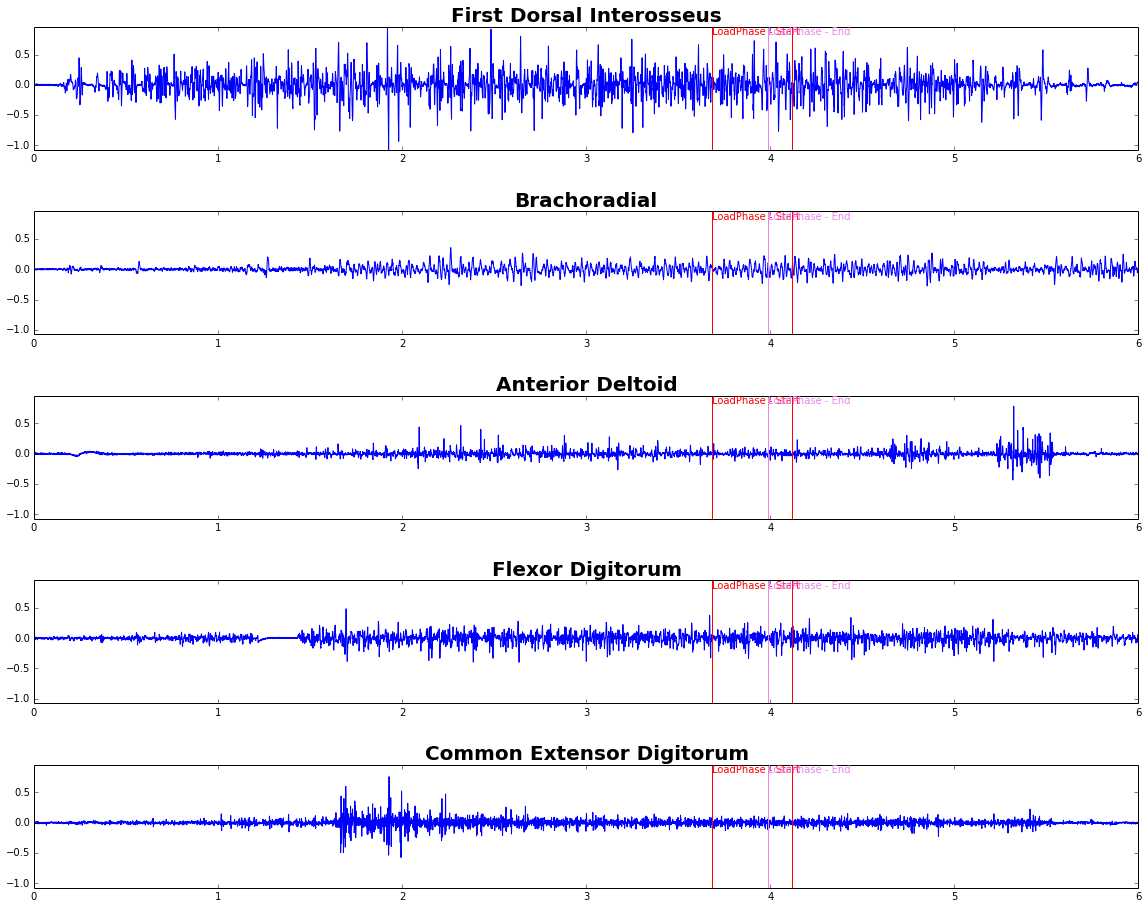

In [8]:
start = 0
stop = 6
display.visualize_modality(element=experiment.get_recording('emg_data', 'session_1'), start=0, stop=stop)

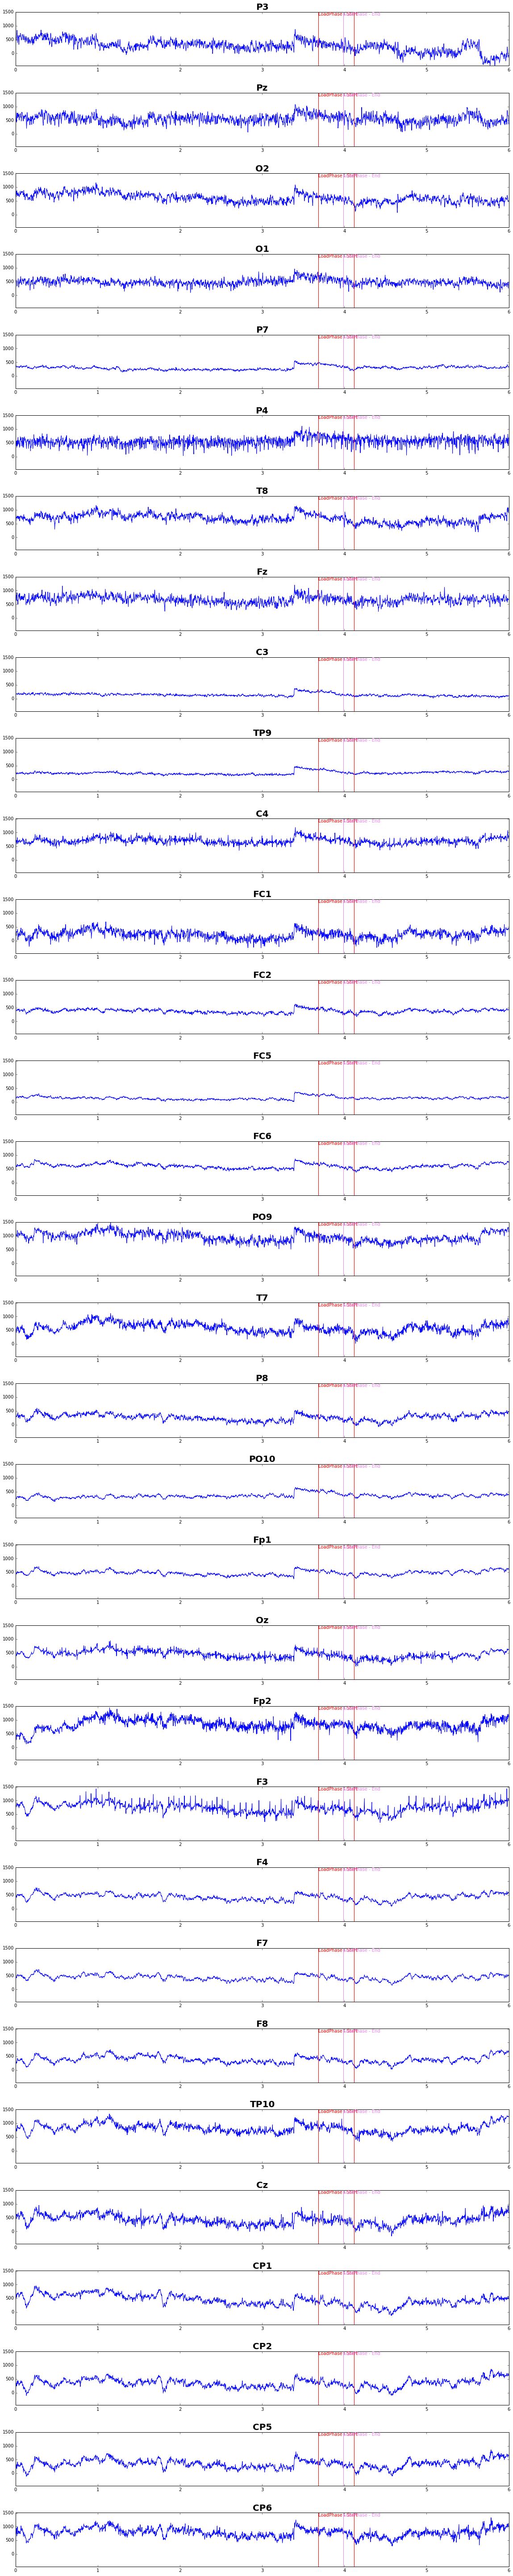

In [9]:
start = 0
stop = 6
display.visualize_modality(element=experiment.get_recording('eeg_data', 'session_1'), start=0, stop=stop)

## Training a linear model to predict kartesian coordinates - For each time step
The following cells show how to prepare data and train a linear model to predict to position of the arm given the
EMG signal.
The prediction is done for every time step, though.

A pipeline of decorators is build. First, data is rectified, then sampling rate is adjusted to 500Hz and trials stacked together to form a 2-dimensional array. At the hart is ``experiment`` object. It could also be an instance of ``Session`` or ``Recording``, though.

In [45]:
generator = decorators.ArrayDecorator2D(
    decorators.SamplingDecorator(500,
        decorators.RectificationDecorator(experiment)
    )
)

Data is retrieved from experiment based on modality. In case of the kinematic data only three channels are wanted, so a respective argument is passed to the method ``get_data``.

In [46]:
emg_data = generator.get_data(modality='emg')
kin_data = generator.get_data(modality='kin', **{'channels': ['Px1', 'Py1', 'Pz1']})

In [47]:
train = int(emg_data.shape[0] * 0.6)
val = int(emg_data.shape[0] * 0.2) + train

In [48]:
X = emg_data[:train]
VX = emg_data[train:val]
TX = emg_data[val:]

In [49]:
Z = kin_data[:train]
VZ = kin_data[train:val]
TZ = kin_data[val:]

Create and train a linear model. Then make prediction and visualize them

In [15]:
m = LinearRegression()
m.fit(X, Z)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
Y = m.predict(X)
VY = m.predict(VX)
TY = m.predict(TX)

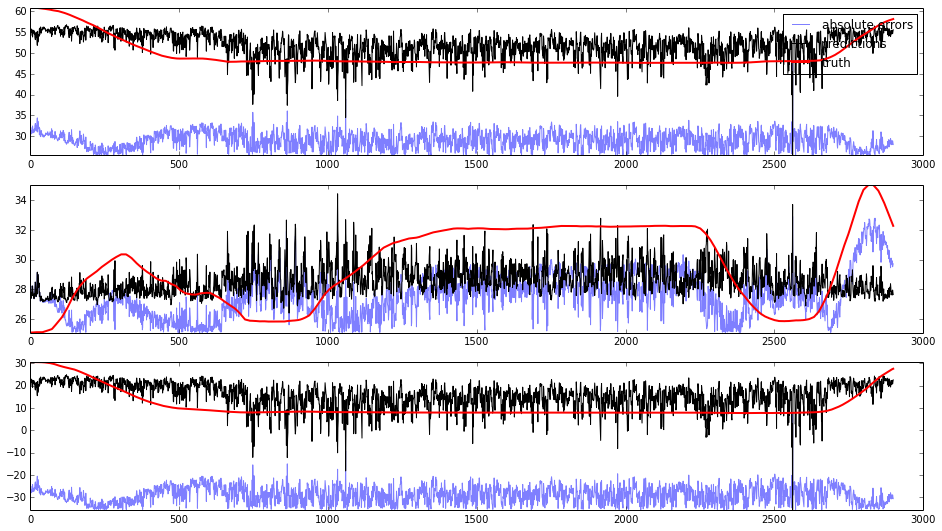

In [17]:
start, stop = 100, 3000
display.predict_report(X[start:stop], Y[start:stop], Z[start:stop])

## Training Linear Model to predict Cartesian Coordinates - Sequence Wise
In contrast to earlier, in this section the model becomes a whole sequence of times steps. The target is the last cartesian coordinate of the sequence.

Exemplary, we have a sequence (time window) of ten samples, **_X_** = *{* **_x1_**, **_x2_**, ..., **_x10_** *}*, where each sample is a vector of length 5 and the corresponding targets **_Z_** = *{* **_z1_**, ...,**_z10_** *}* where each target is a vector of length three. So **_X_** is *10x5* and **_Z_** is *10x3*.

For sequence prediction we flatten out **_X_** to a vector **_v_** of length 50 and use the last target in **_Z_** as target for **_v_**.
The resulting training sample looks then like this:

**_v_** = *(x1,1; x1,2; ...; x1,5; x2,1; ...;x2,5; x3,1; ...; x10, 5)* --> *(z10,1; z10,2; z10, 3)*

In contrast to earlier, the ``ArrayDecorator3D`` is used, yielding an 3D array. Before that, ``WindowDecorator`` is used to windowify the data into windows of one second length with three seconds of spacing between the start of each consecutive window.

In [38]:
generator = decorators.ArrayDecorator3D(
    decorators.WindowDecorator(1,
        decorators.SamplingDecorator(500,
            decorators.RectificationDecorator(experiment)
        )
    , stride=3
    )
)

In [39]:
emg_data = generator.get_data(modality='emg')
kin_data = generator.get_data(modality='kin', **{'channels': ['Px1', 'Py1', 'Pz1']})

Select the last sample from the kinematic data in the window to act as targets and flatten out the second dimension of the array

In [40]:
emg_data = emg_data.reshape(83, -1)
kin_data = np.row_stack([kin_data[k, -1, :] for k in range(83)])

In [41]:
train = int(emg_data.shape[0] * 0.6)
val = int(emg_data.shape[0] * 0.2) + train

In [42]:
X = emg_data[:train]
VX = emg_data[train:val]
TX = emg_data[val:]

In [43]:
Z = kin_data[:train]
VZ = kin_data[train:val]
TZ = kin_data[val:]

In [44]:
m_seq = LinearRegression()
m_seq.fit(X, Z)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
Y = m_seq.predict(X)
VY = m_seq.predict(VX)
TY = m_seq.predict(TX)

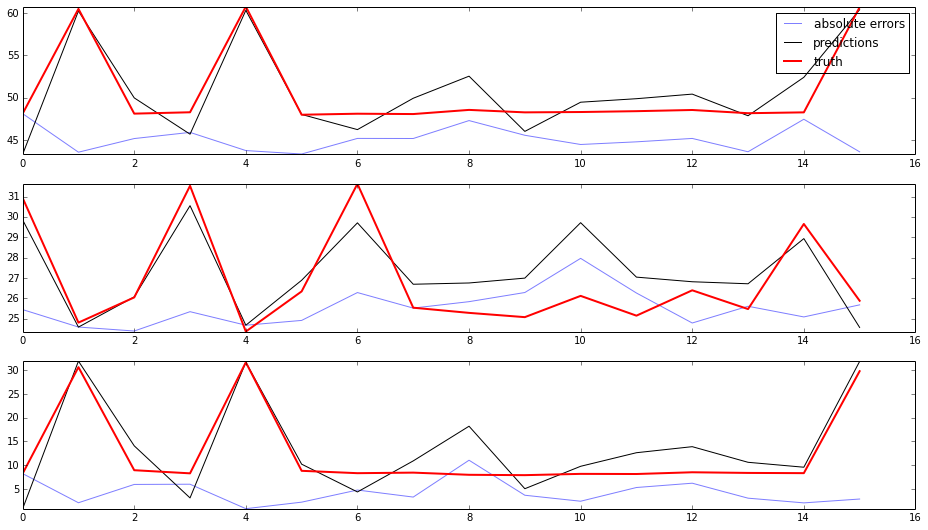

In [26]:
start, stop = 0,16
display.predict_report(TX[start:stop], TY[start:stop], TZ[start:stop])

# Integration with climin

Shows how decorators can be combined with climin and how the generator functionality of decorators work.

Hack to create validation data

In [67]:
generator = decorators.ArrayDecorator3D(
    decorators.WindowDecorator(1,
        decorators.SamplingDecorator(500,
            decorators.RectificationDecorator(experiment)
        )
    , stride=3
    )
)
emg_val = generator.get_data(modality='emg')
kin_val = generator.get_data(modality='kin', **{'channels': ['Px1', 'Py1', 'Pz1']})
emg_val = emg_val.reshape(83, -1)
kin_val = np.row_stack([kin_val[k, -1, :] for k in range(83)])

In [68]:
generator = decorators.WindowDecorator(
    1,
    decorators.SamplingDecorator(
        500,
        decorators.RectificationDecorator(experiment, as_iterator=True),
        as_iterator=True
    ),
    stride=3,
    as_iterator=True
)

In [69]:
emg_data = generator.get_data(modality='emg')
kin_data = generator.get_data(modality='kin', **{'channels': ['Px1', 'Py1', 'Pz1']})

Because data is finite, generators need to be restarted

In [70]:
def args(emg, kin):
    while True:
        try:
            e = emg.next()
            k = kin.next()
        except StopIteration:
            emg = generator.get_data(modality='emg')
            kin = generator.get_data(modality='kin', **{'channels': ['Px1', 'Py1', 'Pz1']})
            continue
        yield ([e.data.reshape(1, -1), k.data[-1, :]], {})

In [71]:
model = regression.LinReg(2500, 3, 2500, 'sigmoid')

In [72]:
optimizer = GradientDescent(
    wrt=model._climin_W,
    fprime=model.climin_grad, 
    args=args(emg_data, kin_data)
)

In [73]:
for info in optimizer:
    if info['n_iter'] % 20 == 0:
        print model.climin_loss(emg_val, kin_val)
    if info['n_iter'] > 100:
        break

1851928.9119
4614780.25314
8675118.67364
14032569.9484
20687700.8972


# Online Learning over Network

This is exemplary code on how to use the online package. Unfortunately it does not work out of the ipython notebook

In [ ]:
e = threading.Event()
try:
    urlemg = 'tcp://192.168.0.20:5555'
    emgp = online.publisher.EmgPublisher(urlemg, abort=e)
    emgs = online.sources.sources.FileSource(emgp, 4000, 'emg_data', abort=e)
    emgsub = online.subscriber.EmgSubscriber(urlemg, abort=e)
    emgiter = online.subscriber.array_iterator(ArrayMessage, emgsub)

    urlkin = 'tcp://192.168.0.20:5556'
    kinp = online.publisher.KinPublisher(urlkin, abort=e)
    kins = online.sources.FileSource(kinp, 500, 'kin_data', abort=e)
    kinsub = online.subscriber.KinSubscriber(urlkin, abort=e)
    kiniter = online.subscriber.array_iterator(ArrayMessage, kinsub)

    #sigmoid = lambda X: 1 / (1 + np.exp(X))
    identity = lambda X: X

    model = regression.LinReg(
        dim_in=ArrayMessage.duration * kins.samplingrate * 5,
        dim_out=ArrayMessage.duration * kins.samplingrate * 3,
        dim_basis=ArrayMessage.duration * kins.samplingrate * 5,
        basis_fcts=identity
        )
    print 'start threads'
    emgp.start()
    emgs.start()
    emgsub.start()
    kinp.start()
    kins.start()
    kinsub.start()

    count = 0
    while count < 1000:
        Z = kiniter.next().data[:, [2,7,9]]
        X = emgiter.next().data
        X_ = X.reshape(Z.shape[0], -1, X.shape[1])
        X = np.mean(X_, axis=1)
        Z = Z.flatten().reshape(1, -1)
        X = X.flatten().reshape(1, -1)
        model.train(X,Z)
        if count % 1 == 0:
            print '{}\t\t{}'.format(count, model.loss(X, Z))
        count += 1
    e.set()
except Exception as ex:
    e.set()
    raise ex
e.set()